In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
df = pd.read_csv(r'Datasets\winequality-red.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
print(df)

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1594            6.2             0.600         0.08             2.0      0.090   
1595            5.9             0.550         0.10             2.2      0.062   
1596            6.3             0.510         0.13             2.3      0.076   
1597            5.9             0.645         0.12             2.0      0.075   
1598            6.0             0.310         0.47             3.6      0.067   

      free sulfur dioxide  

In [9]:
df = df.dropna()
X = df.drop(columns=['quality'])  # Drop 'quality' column to get features
y = df['quality']  # Target variable 'quality'

In [11]:
class WineDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
        # Standardize features
        self.scaler = StandardScaler()
        self.X = self.scaler.fit_transform(self.X)
        
        # Convert to PyTorch tensors
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y.values, dtype=torch.float32).unsqueeze(1)  # Add extra dimension for single output

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [40]:
class WineQualityNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        super(WineQualityNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [37]:
dataset = WineDataset(X, y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [53]:
input_size = X.shape[1]
output_size = 1
hidden_size = 64
dropout_rate = 0.5
learning_rate = 0.01
num_epochs = 200

In [54]:
# Model, loss function, and optimizer
model = WineQualityNN(input_size, hidden_size, output_size, dropout_rate)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Training loop with learning curve
train_losses = []
val_losses = []

In [55]:
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    val_losses.append(val_loss / len(test_loader))
    model.train()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')


Epoch [10/200], Train Loss: 1.2330, Val Loss: 0.8327
Epoch [20/200], Train Loss: 0.8438, Val Loss: 0.5136
Epoch [30/200], Train Loss: 0.6832, Val Loss: 0.4129
Epoch [40/200], Train Loss: 0.6195, Val Loss: 0.4121
Epoch [50/200], Train Loss: 0.5550, Val Loss: 0.4119
Epoch [60/200], Train Loss: 0.5046, Val Loss: 0.4095
Epoch [70/200], Train Loss: 0.4521, Val Loss: 0.4107
Epoch [80/200], Train Loss: 0.4189, Val Loss: 0.4073
Epoch [90/200], Train Loss: 0.4155, Val Loss: 0.4308
Epoch [100/200], Train Loss: 0.4088, Val Loss: 0.4128
Epoch [110/200], Train Loss: 0.4136, Val Loss: 0.4266
Epoch [120/200], Train Loss: 0.4089, Val Loss: 0.4183
Epoch [130/200], Train Loss: 0.3995, Val Loss: 0.4037
Epoch [140/200], Train Loss: 0.3953, Val Loss: 0.4509
Epoch [150/200], Train Loss: 0.4023, Val Loss: 0.4172
Epoch [160/200], Train Loss: 0.4003, Val Loss: 0.4196
Epoch [170/200], Train Loss: 0.3731, Val Loss: 0.4163
Epoch [180/200], Train Loss: 0.4085, Val Loss: 0.4245
Epoch [190/200], Train Loss: 0.3799, 

In [57]:
model.eval()
with torch.no_grad():
    test_predictions = []
    test_actuals = []
    for inputs, targets in test_loader:
        outputs = model(inputs)
        test_predictions.append(outputs.numpy())
        test_actuals.append(targets.numpy())

    test_predictions = np.vstack(test_predictions)
    test_actuals = np.vstack(test_actuals)
    test_mae = mean_absolute_error(test_actuals, test_predictions)
    test_r2 = r2_score(test_actuals, test_predictions)

print(f'Test MAE: {test_mae:.4f}')
print(f'Test R2: {test_r2:.4f}')

Test MAE: 0.4979
Test R2: 0.3828


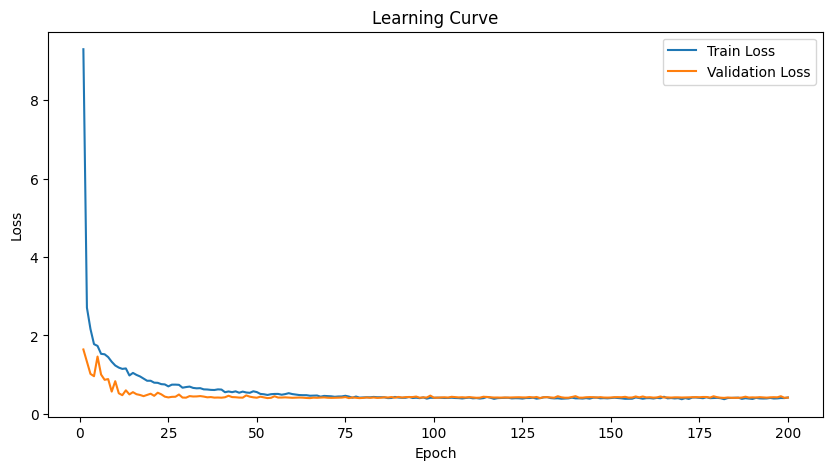

In [58]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve')
plt.show()